In [1]:
import sys
assert sys.version_info >= (3,7)

In [2]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size = 14)
plt.rc("axes", labelsize = 14, titlesize = 14)
plt.rc("legend", fontsize = 14)
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)

### Linear Regression

#### The Normal Equation

In [4]:
import numpy as np

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m , 1)
y = 4 + 3 * X + np.random.rand(m, 1)


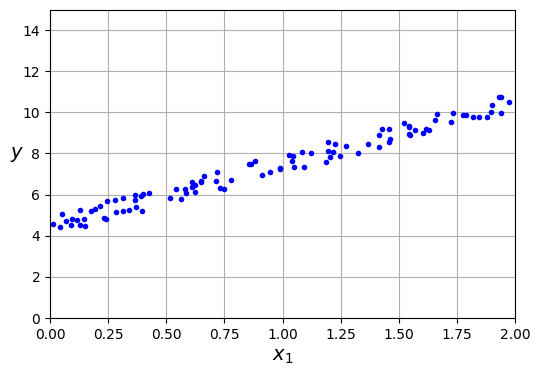

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.grid()
plt.axis([0,2,0,15])

plt.show()

In [6]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[4.51359766],
       [2.98323418]])

In [7]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[ 4.51359766],
       [10.48006601]])

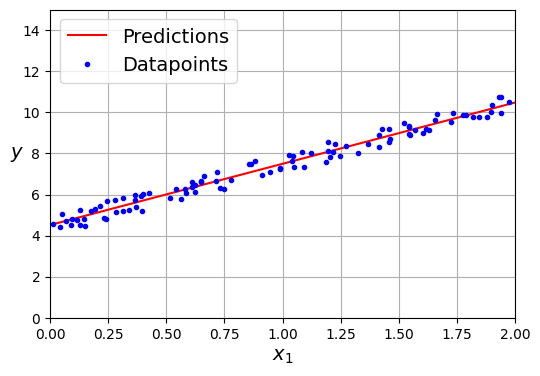

In [8]:
plt.figure(figsize=(6,4))
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X,y, "b.", label = "Datapoints")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.grid()
plt.axis([0,2,0,15])
plt.legend(loc="upper left")

plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.51359766]), array([[2.98323418]]))

In [10]:
lin_reg.predict(X_new)

array([[ 4.51359766],
       [10.48006601]])

In [11]:
eta = 0.1
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    gradients = 2/ m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta


array([[4.51359766],
       [2.98323418]])

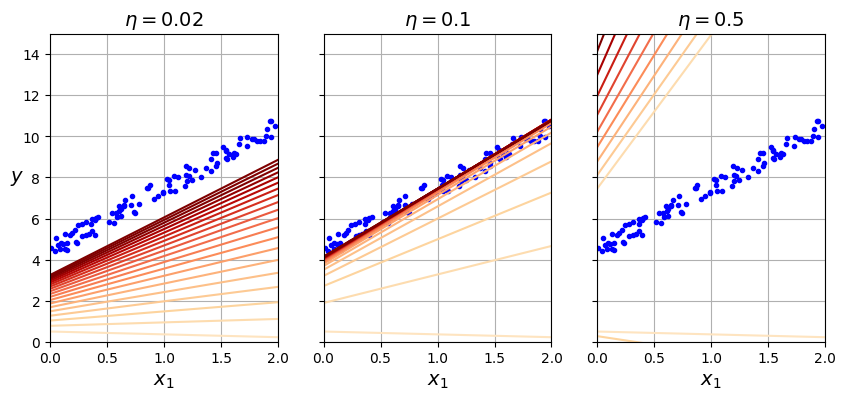

In [12]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []

    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15) )
            plt.plot(X_new, y_predict, linestyle="solid", color = color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)

    plt.xlabel("$x_1$")
    plt.axis([0,2,0,15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")

    return theta_path
            

np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation = 0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta = 0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta = 0.5)
plt.show()

#### Stochastic Gradient Descent using a simple learning schedule

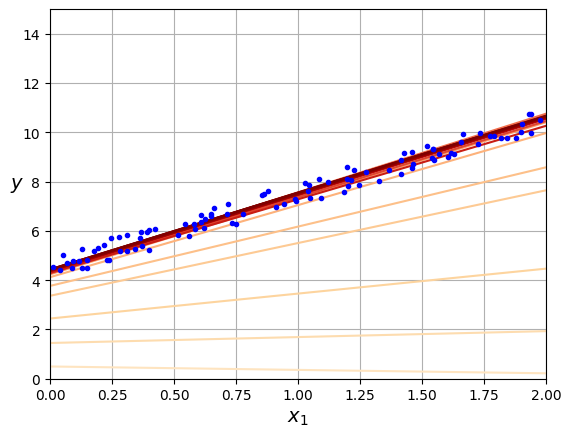

In [13]:
n_epochs = 50
t0, t1 = 5, 50
n_shown = 20
theta_path_sgd = []

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for iteration in range(m):

        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color = color)

        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index + 1]
        yi = y[random_index: random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.axis([0,2,0, 15])
plt.grid()
plt.show()

In [14]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X,y.ravel())

,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.50316965]), array([2.99156535]))

#### Mini Batch Gradient Descent

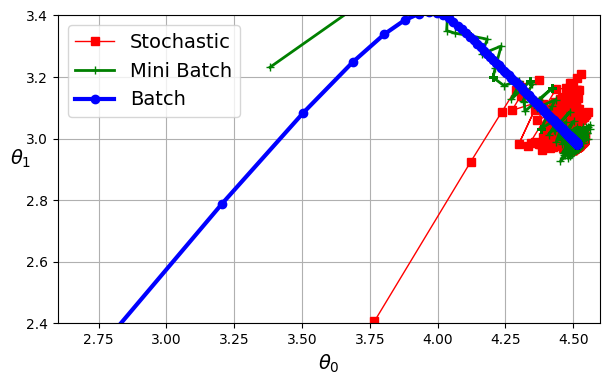

In [16]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2,1)

t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    for iteration in range(n_epochs):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx: idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize = (7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth = 1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:,1], "g-+", linewidth=2,
         label="Mini Batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:,1], "b-o", linewidth=3,
         label="Batch")

plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$", rotation = 0)
plt.axis([2.6, 4.6, 2.4, 3.4])
plt.grid()

plt.show()


### Polynomial Regression

In [17]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m , 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m , 1)

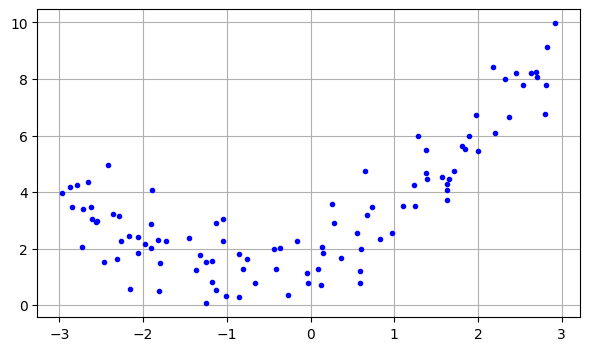

In [18]:
plt.figure(figsize=(7,4))
plt.plot(X, y, "b.")
plt.grid()

plt.show()

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_


(array([1.78134581]), array([[0.93366893, 0.56456263]]))

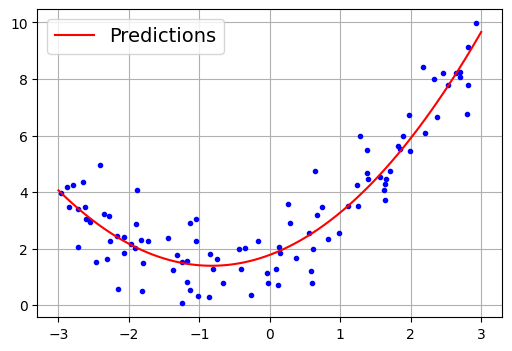

In [21]:
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6,4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", label="Predictions")
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [22]:
X

array([[-0.75275929],
       [ 2.70428584],
       [ 1.39196365],
       [ 0.59195091],
       [-2.06388816],
       [-2.06403288],
       [-2.65149833],
       [ 2.19705687],
       [ 0.60669007],
       [ 1.24843547],
       [-2.87649303],
       [ 2.81945911],
       [ 1.99465584],
       [-1.72596534],
       [-1.9090502 ],
       [-1.89957294],
       [-1.17454654],
       [ 0.14853859],
       [-0.40832989],
       [-1.25262516],
       [ 0.67111737],
       [-2.16303684],
       [-1.24713211],
       [-0.80182894],
       [-0.26358009],
       [ 1.71105577],
       [-1.80195731],
       [ 0.08540663],
       [ 0.55448741],
       [-2.72129752],
       [ 0.64526911],
       [-1.97685526],
       [-2.60969044],
       [ 2.69331322],
       [ 2.7937922 ],
       [ 1.85038409],
       [-1.17231738],
       [-2.41396732],
       [ 1.10539816],
       [-0.35908504],
       [-2.26777059],
       [-0.02893854],
       [-2.79366887],
       [ 2.45592241],
       [-1.44732011],
       [ 0

#### Learning Curves

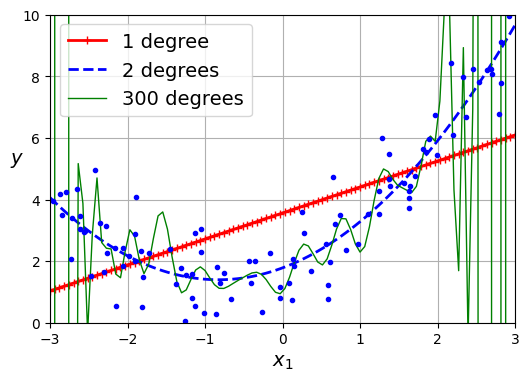

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6,4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2,2), ("g-", 1,300)):
    polybig_features = PolynomialFeatures(degree = degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{"s" if degree > 1 else ""}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth = width)

plt.plot(X, y, "b.")
plt.grid()
plt.axis([-3,3,0,10])
plt.xlabel("$x_1$")
plt.ylabel("$y$",rotation = 0)
plt.legend(loc="upper left")

plt.show()

In [24]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40),cv=5,
    scoring="neg_root_mean_squared_error"
)
train_errors = -train_scores.mean(axis = 1)
valid_errors = -valid_scores.mean(axis = 1)
train_errors, valid_errors

(array([-0.00000000e+00,  3.40032635e-16,  1.21917626e+00,  1.55444643e+00,
         1.67538750e+00,  1.66043001e+00,  1.87246874e+00,  1.77194988e+00,
         1.73293770e+00,  1.77993138e+00,  1.76856361e+00,  1.77297636e+00,
         1.80788097e+00,  1.75305712e+00,  1.75504512e+00,  1.76723624e+00,
         1.75137416e+00,  1.78154893e+00,  1.75109417e+00,  1.76356708e+00,
         1.74809325e+00,  1.76183606e+00,  1.76981557e+00,  1.74279296e+00,
         1.73842344e+00,  1.77957666e+00,  1.79762131e+00,  1.78590497e+00,
         1.76560991e+00,  1.74736661e+00,  1.75519418e+00,  1.75392236e+00,
         1.76470581e+00,  1.74127910e+00,  1.74945465e+00,  1.75076847e+00,
         1.74085617e+00,  1.73672095e+00,  1.73915788e+00,  1.73796725e+00]),
 array([2.80211523, 2.4866149 , 3.10778145, 1.83476451, 1.81585796,
        1.84822263, 1.83766998, 1.76806648, 1.75211426, 1.7420777 ,
        1.74526237, 1.75197152, 1.76503282, 1.76326358, 1.7821654 ,
        1.77464973, 1.78066051, 1.

In [25]:
(train_scores.shape), (train_errors.shape)

((40, 5), (40,))

In [26]:
train_sizes

array([ 1,  2,  4,  6,  8, 10, 12, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 80])

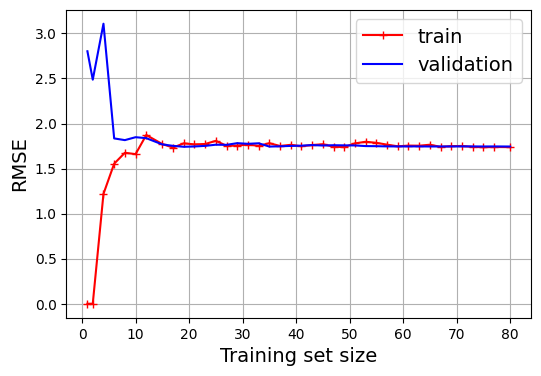

In [27]:
plt.figure(figsize=(6,4))
plt.plot(train_sizes,train_errors, "r-+", label = "train")
plt.plot(train_sizes, valid_errors, "b-", label = "validation")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc = "upper right")

plt.show()

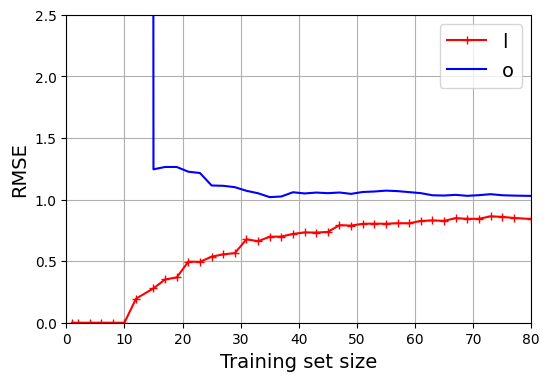

In [28]:
polynomial_regression = make_pipeline(PolynomialFeatures(degree = 10, include_bias=False),
                                      LinearRegression())
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, scoring = "neg_root_mean_squared_error",
    train_sizes=np.linspace(0.01, 1.0, 40), cv = 5
)

train_errors = -train_scores.mean(axis = 1)
valid_errors = -valid_scores.mean(axis = 1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", label = "train")
plt.plot(train_sizes, valid_errors, "b-", label = "validation")
plt.grid()
plt.xlabel("Training set size")
plt.ylabel("RMSE")
# plt.grid()
plt.axis([0,80,0,2.5])
plt.legend("loc = upper right")

plt.show()

### Regularized Linear Models

A good way to reduce overfitting is to regularize the model ( i.e. contrain it): the fewer degrees of freedom it has, the harder will be for it to overfit the data.

A simple linear model is regularized by constraining its weights

#### Ridge Regression

This term is added to the cost function - $\alpha / m \sum_{i=1}^{n} \theta_i^2$

Make sure to scale the data before using regularized linear models.

In [29]:
np.random.seed(42)

m = 20
X = 3 * np.random.randn(m, 1)
y = 1 + 0.5 * X + np.random.rand(m, 1) / 1.5
X_new = np.linspace(0,7,100).reshape(100,1)
# X_new will be used for predictions

[]

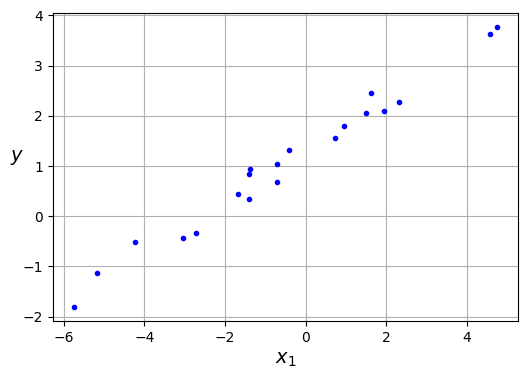

In [30]:
plt.figure(figsize=(6,4))
plt.plot(X, y, "b.")
plt.grid()
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)

plt.plot()

In [31]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([2.06760937])

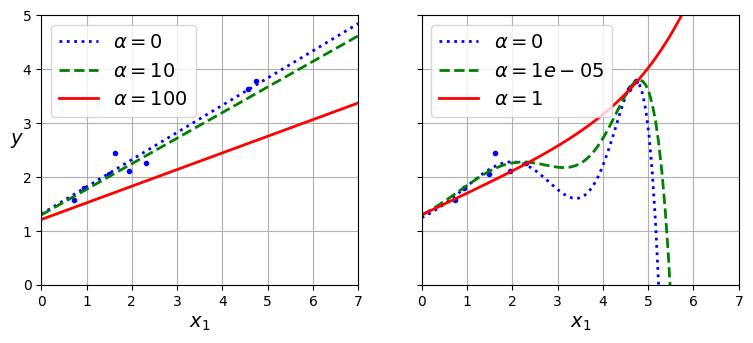

In [32]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.")
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()

        if polynomial:
            model = make_pipeline(PolynomialFeatures(degree = 10,
                                       include_bias=False),
                                       StandardScaler(),
                                       model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth = 2,
                 label = fr"$\alpha = {alpha}$")
        plt.axis([0,7,0,5])
    
    plt.legend(loc = "upper left")
    plt.grid()

plt.figure(figsize=(9,3.5))
plt.subplot(121)
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plot_model(Ridge, polynomial=False, alphas=(0,10, 100), random_state = 42)

plt.subplot(122)
plt.xlabel("$x_1$")
plot_model(Ridge, polynomial=True, alphas = (0, 10 ** -5, 1), random_state = 42)
plt.gca().axes.yaxis.set_ticklabels([])

plt.show()  

Using Stochastic Gradient Descent 

In [33]:
sgd_reg = SGDRegressor(penalty="l2", alpha = 0.1 / m, tol=None,
                   max_iter = 1000, eta0 = 0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([2.06748178])

In [34]:
ridge_reg = Ridge(alpha = 0.1, solver="sag")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([2.06764547])

### Lasso Regression

$J(\theta) = \text{MSE}(\theta) + 2\alpha\sum_{i=1}^{n} |\theta_i|$ 


In [35]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.01)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([2.06569856])

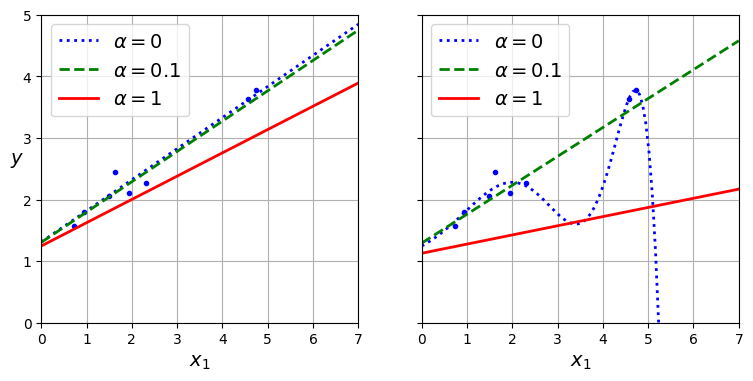

In [36]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False,alphas = (0,0.1,1), random_state=42)
plt.ylabel("$y$", rotation = 0)
plt.xlabel("$x_1$")

plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas = (0,0.1,1), random_state=42)
plt.gca().axes.set_yticklabels([])
plt.xlabel("$x_1$")

plt.show()

Here T is a massive list of candidates we want to test so that we can get an idea of cost.

Xr is the input and y is the output with (2,0.5) as its coefficients.

In [55]:
# the boundaries of our plot, t1 for theta 1 and t2 for theta 2
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]

Xr = np.array([[1,1], [1,-1], [1,0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

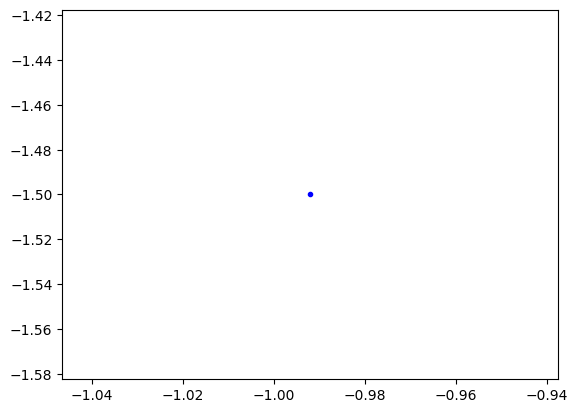

In [56]:
plt.plot(t1[0][1], t2[0][1], "b.")
plt.show()

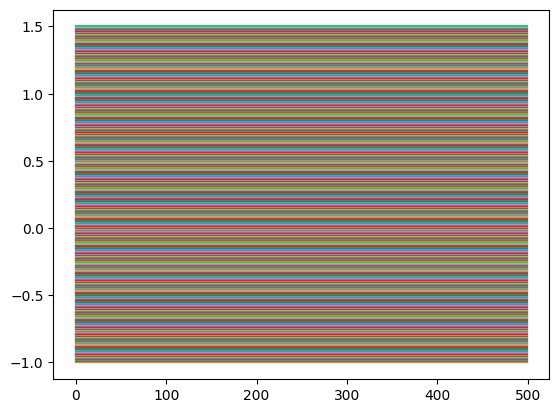

In [39]:
plt.plot(t1)
plt.show()

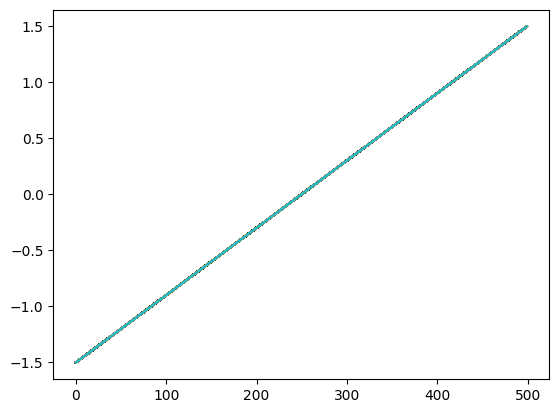

In [40]:
plt.plot(t2)
plt.show()

In [41]:
t1.shape,  t2.shape

((500, 500), (500, 500))

In [42]:
T.shape, Xr.shape, t1.shape, J.shape

((250000, 2), (3, 2), (500, 500), (500, 500))

N1 and N2 is the penalty for each candidate according to their norm. N1 contains L1 penalty and N2 contains L2 penalty.

In [57]:
N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord = 2, axis = 1).reshape(t1.shape)

In [59]:
t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])


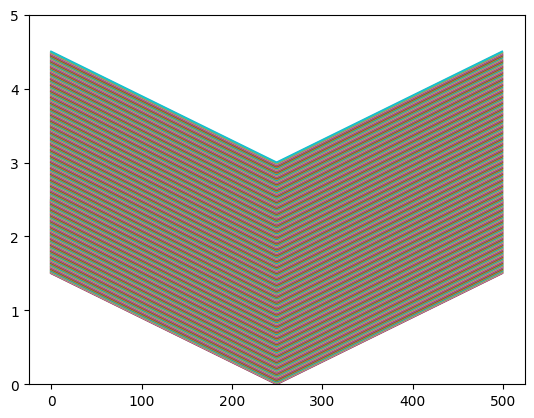

In [60]:
plt.plot(N1)
# plt.axes([0,500, 0,10])
# plt.xlim(0,1000)
plt.ylim(0,5)
plt.show()

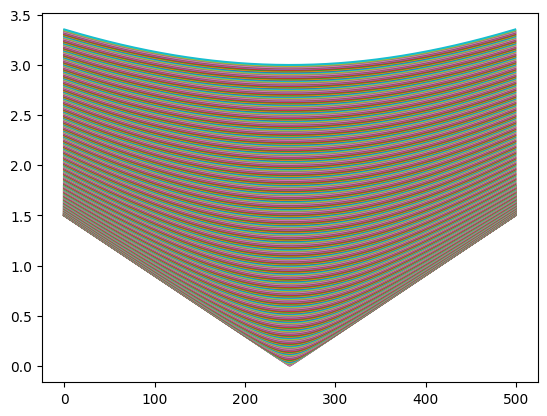

In [61]:
plt.plot(N2)
plt.show()

In the next

In [62]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta)
                     + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

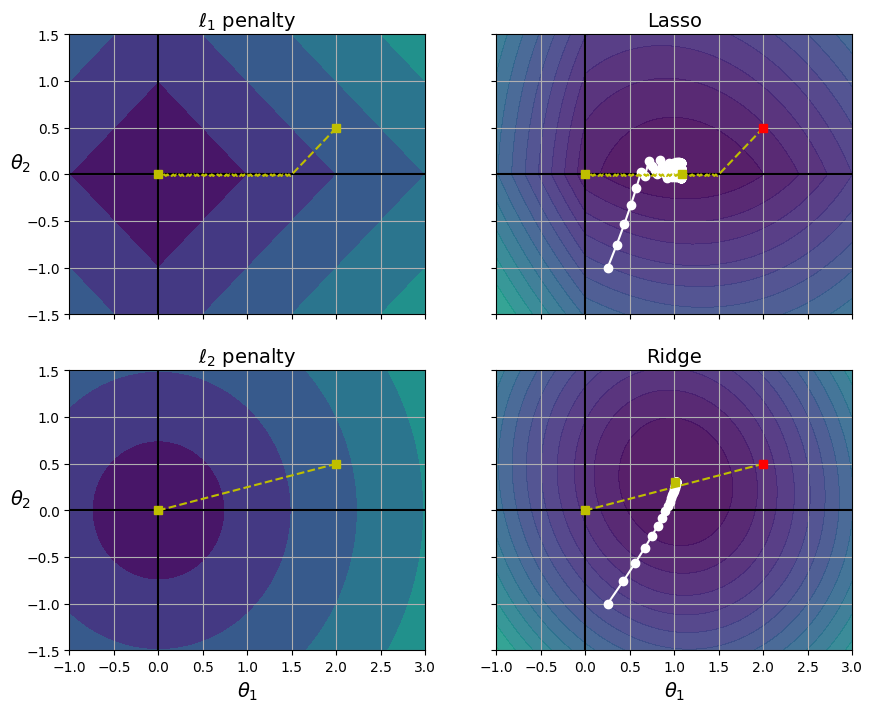

In [65]:
fig, axes = plt.subplots(2,2,sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1,l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
                         JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

                         tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
                         t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

                         levels = np.exp(np.linspace(0,1,20)) - 1
                         levelsJ = levels * (J.max() - J.min()) + J.min()
                         levelsJR = levels * (JR.max() - JR.min()) + JR.min()
                         levelsN = np.linspace(0, N.max(), 10)

                         path_J = bgd_path(t_init, Xr, yr, l1 = 0, l2 = 0)
                         path_JR = bgd_path(t_init, Xr, yr, l1, l2)
                         path_N = bgd_path(theta = np.array([[2.0],[0.5]]), X = Xr, y = yr,
                                        l1 = np.sign(l1) / 3, l2 = np.sign(l2), core = 0)
                           
                         ax = axes[i, 0]
                         ax.grid()
                         ax.axhline(y = 0, color="k")
                         ax.axvline(x = 0, color = "k")
                         ax.contourf(t1, t2, N / 2.0, levels = levelsN)
                         ax.plot(path_N[:, 0], path_N[:,1], "y--")
                         ax.plot(0,0, "ys")
                         ax.plot(t1_min, t2_min, "ys")
                         ax.set_title(fr"$\ell_{i + 1}$ penalty")
                         ax.axis([t1a, t1b, t2a, t2b])
                         if i == 1:
                              ax.set_xlabel(r"$\theta_1$")
                         ax.set_ylabel(r"$\theta_2$", rotation = 0)
                    
                         ax = axes[i,1]
                         ax.grid()
                         ax.axhline(y = 0, color = "k")
                         ax.axvline(x = 0, color = "k")
                         ax.contourf(t1, t2, JR, levels = levelsJR, alpha = 0.9)
                         ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
                         ax.plot(path_N[:, 0], path_N[:, 1], "y--")
                         ax.plot(0, 0, "ys")
                         ax.plot(t1r_min, t2r_min, "ys")
                         ax.plot(t1_min, t2_min, "rs")
                         ax.set_title(title)
                         ax.axis([t1a, t1b, t2a, t2b])
                         if i == 1:
                                 ax.set_xlabel(r"$\theta_1$")

plt.show()



In [66]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([2.04269764])

#### Elastic Net Regression

Tis a middle ground between ridge and lasso regression. The regularization term is a weighted sum of both ridge's and lasso's regularization terms and we can control it with r. When r = 0, elastic net is equal to ridge and when r = 1, it is equal to lasso.

In [67]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio= 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([2.04914459])

#### Early Stopping

In this, we just stop traning when the validation error is minimum. We can do this if we detect that the validation error has started to increase, and when it does, we stop it.

In [69]:
from sklearn.metrics import root_mean_squared_error

In [70]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[:m // 2], y[:m // 2]
X_valid, y_valid = X[m // 2:], y[m // 2:]

preprocessing = make_pipeline(PolynomialFeatures(degree= 90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0 = 0.002, random_state = 42)
n_epochs = 500
best_valid_rmse = float("inf")
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = root_mean_squared_error(y_train, y_train_predict)
    val_errors.append(val_error)
    train_errors.append(train_error)


/home/krekken/Hands-on-ML/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krekken/Hands-on-ML/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krekken/Hands-on-ML/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krekken/Hands-on-ML/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d

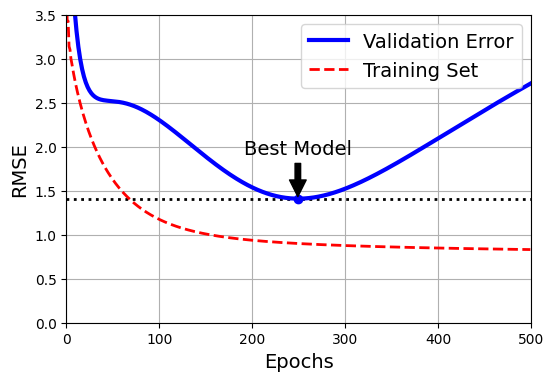

In [80]:
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6,4))
plt.annotate("Best Model", xy=(best_epoch,best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha = "center",
             arrowprops=dict(facecolor = "black", shrink = 0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth =2)
plt.plot(val_errors, "b-", linewidth = 3, label = "Validation Error")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", label = "Training Set", linewidth = 2)
plt.legend(loc = "upper right")
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])

plt.show()

### Logistic Regression

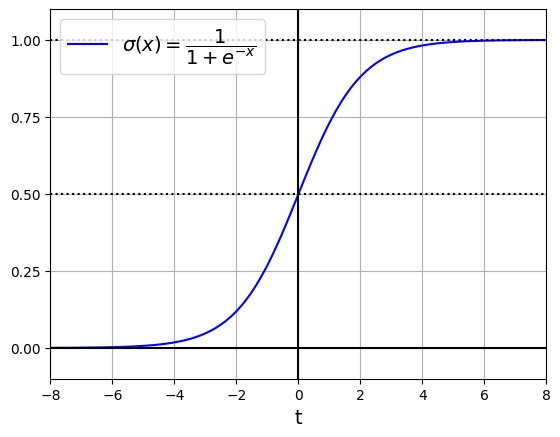

In [96]:
X = np.linspace(-8, 8, 100)
y = 1 / (1 + np.exp(-X))

plt.plot(X, y, "b-", label = r"$\sigma(x) = \dfrac{1}{1 + e^{-x}}$")

plt.axis([-8,8, -0.1, 1.1])
plt.plot([-8,8], [1,1],"k:")
plt.plot([-8,8], [0,0], "k-")
plt.plot([-8,8], [0.5, 0.5], "k:")
plt.plot([0,0], [-1.1, 1.1], "k-")
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.legend(loc = "upper left")
plt.xlabel("t")
plt.grid()


plt.show()